# Voice conversion prototyping

with GMMs; Arctic corpus

In [1]:
# open data
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "Documents/em_lct/UoM/thesis/data", "arctic2")
!ls $DATA_ROOT

BDL  CLB  EBVS HKK  NJS  RRBI TNI  YDCK


In [2]:
# nnmnkwii imports taken from example notebook on VC
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset, FileDataSource
# from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os import listdir
from os.path import basename, splitext, join, splitext, isdir
import sys
import time

import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


/Users/kennylino/.local/share/virtualenvs/thesis-W2ZHkp3l/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 150 # number of utterances to be used.
test_size = 0.33
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [4]:
def _name_to_dirname(name):
    return join(name.upper(), "wav")

class ArcticFileDataSource(FileDataSource):
    """Wav file data source for CMU Arctic AND L2-ARCTIC dataset.
    
    Files were pre-organized into the same root folder before using this class.
    
    Code from https://r9y9.github.io/nnmnkwii/latest/_modules/nnmnkwii/datasets/cmu_arctic.html
    was modified to expand support to L2-ARCTIC.

    The data source collects wav files from CMU Arctic and L2-ARCTIC.
    Users are expected to inherit the class and implement ``collect_features``
    method, which defines how features are computed given a wav file path.

    Args:
        data_root (str): Data root.
        speakers (list): List of speakers to find. Supported names of speaker
         are any speakers in CMU Arctic and L2-ARCTIC corpus.
        labelmap (dict[optional]): Dict of speaker labels. If None,
          it's assigned as incrementally (i.e., 0, 1, 2) for specified
          speakers.
        max_files (int): Total number of files to be collected.

    Attributes:
        labels (numpy.ndarray): Speaker labels paired with collected files.
          Stored in ``collect_files``. This is useful to build multi-speaker
          models.
    """
  
    def __init__(self, data_root, speakers, labelmap=None, max_files=None):
        self.data_root = data_root
        self.speakers = speakers
        if labelmap is None:
            labelmap = {}
            for idx, speaker in enumerate(speakers):
                labelmap[speaker] = idx
        self.labelmap = labelmap
        self.max_files = max_files
        self.labels = None
        self.test_paths = None
        self.train_paths = None

    def collect_files(self):
        speaker_dirs = list(
            map(lambda x: join(self.data_root, _name_to_dirname(x)),
                self.speakers))
        paths = []
        labels = []

        if self.max_files is None:
            max_files_per_speaker = None
        else:
            max_files_per_speaker = self.max_files // len(self.speakers)
        for (i, d) in enumerate(speaker_dirs):
            if not isdir(d):
                raise RuntimeError("{} doesn't exist.".format(d))
            files = [join(speaker_dirs[i], f) for f in listdir(d)]
            files = list(filter(lambda x: splitext(x)[1] == ".wav", files))
            files = sorted(files)
            files = files[:max_files_per_speaker]
            for f in files:
                # add if statement here to say "if file id is also in other speaker folder"
                paths.append(f)
                labels.append(self.labelmap[self.speakers[i]])

        self.labels = np.array(labels, dtype=np.int32)
        
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=42)
        
        # keep paths for later testing
        self.train_paths = paths_train
        self.test_paths = paths_test
        
        return paths_train

    def collect_features(self, path):
        x, frame_sample = librosa.load(path, sr=fs, dtype=float64)
        f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

In [5]:
src_speaker = ArcticFileDataSource(data_root=DATA_ROOT, speakers=["BDL"], max_files=max_files)
tgt_speaker = ArcticFileDataSource(data_root=DATA_ROOT, speakers=["EBVS"], max_files=max_files) 

In [7]:
# convert training sets into arrays
X = PaddedFileSourceDataset(src_speaker, 1200).asarray()
Y = PaddedFileSourceDataset(tgt_speaker, 1200).asarray()
print(X.shape)
print(Y.shape) 
# shape = (13 training audios, 2800 frames, 25 features per frame)

(100, 1200, 25)
(100, 1200, 25)


In [14]:
import os.path

In [30]:
#Ensures that the audio files used for training and testing
# are all indeed parallel.
# Returns boolean.

def check_parallel_files(src_speaker, tgt_speaker):
    src_speaker_check = [os.path.split(f)[1][-16] for f in src_speaker] # -16 to remove speaker ID
    tgt_speaker_check = [os.path.split(f)[1][-16] for f in tgt_speaker] # -16 to remove speaker ID
    
    return src_speaker_check == tgt_speaker_check
        

In [31]:
check_parallel_files(src_speaker.train_paths, tgt_speaker.train_paths)

True

In [32]:
check_parallel_files(src_speaker.test_paths, tgt_speaker.test_paths)

True

In [33]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

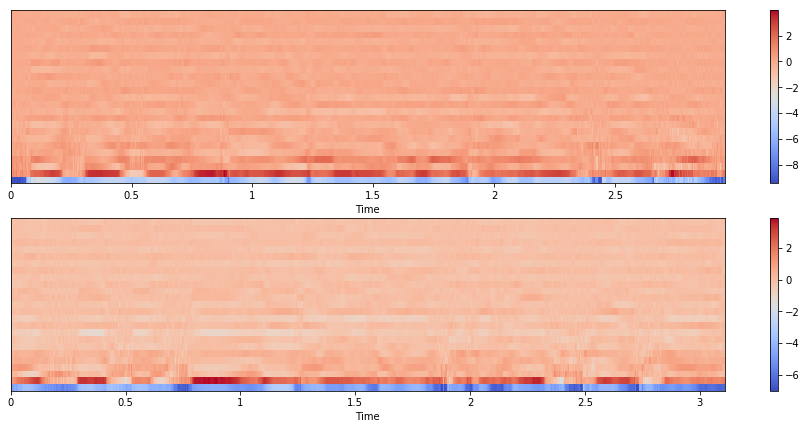

In [34]:
idx = 6 # any 
plot_parallel(X[idx],Y[idx])

In [35]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

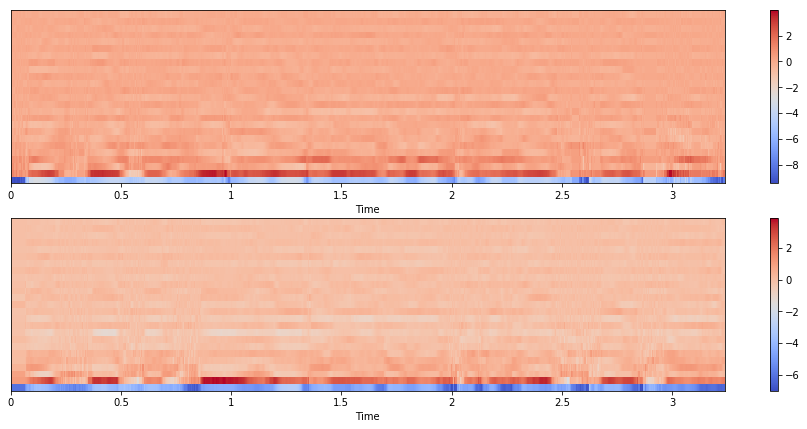

In [36]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

In [37]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

In [38]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

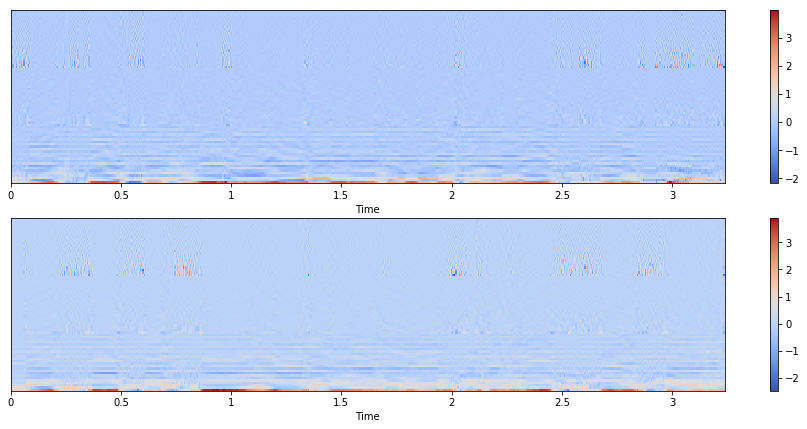

In [39]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

## Kmeans clustering of MFCC feature vectors

### clustering of source speaker

In [40]:
km_X = KMeans(n_clusters=512, init='k-means++', max_iter=100, n_init=1)

In [41]:
X_aligned.shape

(100, 1200, 72)

In [42]:
# concatenates all of the frames in each sentence since k-means needs one large vector
all_frames_X = numpy.concatenate(X_aligned, axis=0)

In [43]:
# should equal number of frames * number of utterances
len(all_frames_X)

120000

In [44]:
all_frames_X.shape

(120000, 72)

In [45]:
all_frames_X[0]

array([ 6.80645466e-01,  4.52154011e-01,  4.85359073e-01, -1.14714630e-01,
       -3.50598216e-01, -1.57449722e-01, -1.30261496e-01,  3.25970978e-01,
       -7.56070483e-03, -1.88170969e-01,  2.53370434e-01, -1.28385529e-01,
       -7.25669116e-02,  8.75799134e-02,  1.51372235e-03, -2.30644960e-02,
        4.81543364e-03, -6.15001773e-04,  2.07221657e-02, -5.65095991e-02,
        7.07060099e-02, -6.29694462e-02,  5.27017117e-02, -3.74574326e-02,
        4.11681324e-01,  2.96513379e-01,  5.03479660e-01,  1.43218920e-01,
       -5.64718060e-02, -4.27100360e-02,  1.58435125e-02, -1.12557717e-01,
       -2.16256268e-03, -2.75595412e-02,  4.66486216e-02, -1.78021416e-02,
       -6.21525273e-02,  5.15491962e-02,  3.43296165e-03, -4.00132537e-02,
        3.92224267e-02, -2.60130838e-02,  2.68814620e-02, -1.90515984e-02,
        2.48402990e-02, -2.12073158e-02,  2.40097530e-02, -2.90453490e-02,
       -5.37928283e-01, -3.11281264e-01,  3.62411737e-02,  5.15867114e-01,
        5.88252842e-01,  

In [46]:
# 0 frames are removed since they are all exactly the same
all_frames_X = remove_zeros_frames(all_frames_X)

In [47]:
len(all_frames_X)

72483

In [49]:
%%time
km_X.fit(all_frames_X)

CPU times: user 1min 16s, sys: 26.2 s, total: 1min 42s
Wall time: 1min 1s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=512, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [50]:
# help taken from: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-values-in-the-cluster
clustered_X = pd.DataFrame()
clustered_X['frame'] = all_frames_X.tolist()
clustered_X['cluster #'] = km_X.labels_

In [51]:
clustered_X.head()

frame  cluster #
0  [0.6806454658508301, 0.4521540105342865, 0.485...        216
1  [0.8233626484870911, 0.5930267572402954, 1.006...         18
2  [0.9945943355560303, 0.6802266836166382, 0.425...        109
3  [0.868552565574646, 0.41492757201194763, 0.184...        264
4  [1.2008333206176758, 0.6673847436904907, 0.544...        292

In [52]:
cluster_dist_X = clustered_X.groupby('cluster #').size()

In [53]:
# use print(cluster_dist_X.to_string()) to see whole dist
print (cluster_dist_X.head)

<bound method NDFrame.head of cluster #
0       99
1      155
2      253
3      136
4      213
5      342
6      269
7      160
8      109
9       85
10     261
11      43
12      75
13      75
14     167
15     124
16      77
17     172
18      66
19      98
20      71
21     222
22      56
23      94
24     257
25     236
26     190
27     100
28     112
29     100
      ... 
482    111
483    224
484    110
485     34
486     31
487     66
488    161
489     47
490     41
491     81
492     47
493    302
494    207
495    120
496     84
497    129
498     46
499    147
500     33
501      2
502    120
503    212
504    269
505    222
506    113
507    111
508    123
509     85
510     84
511    209
Length: 512, dtype: int64>


In [54]:
cluster_dist_X.describe()

count    512.000000
mean     141.568359
std       78.296611
min        2.000000
25%       84.000000
50%      120.000000
75%      190.750000
max      397.000000
dtype: float64

### Clustering of the target speaker data

In [55]:
km_Y = KMeans(n_clusters=512, init='k-means++', max_iter=100, n_init=1)

In [56]:
# concatenates all of the frames in each sentence since k-means needs one large vector
all_frames_Y = numpy.concatenate(Y_aligned, axis=0)

In [57]:
# should equal number of frames * number of utterances
len(all_frames_Y)

120000

In [58]:
all_frames_Y.shape

(120000, 72)

In [59]:
test = all_frames_Y[0]

In [60]:
# 0 frames are removed since they are all exactly the same
all_frames_Y = remove_zeros_frames(all_frames_Y)

In [61]:
%%time
km_Y.fit(all_frames_Y)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=512, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
# help taken from: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-values-in-the-cluster
clustered_Y = pd.DataFrame()
clustered_Y['frame'] = all_frames_Y.tolist()
clustered_Y['cluster #'] = km_Y.labels_

In [63]:
clustered_Y.head()

frame  cluster #
0  [1.5336894989013672, 0.27363821864128113, 0.36...         49
1  [1.5336894989013672, 0.27363821864128113, 0.36...         36
2  [1.5336894989013672, 0.27363821864128113, 0.36...         36
3  [1.5336894989013672, 0.27363821864128113, 0.36...         36
4  [1.5336894989013672, 0.27363821864128113, 0.36...         36

In [64]:
cluster_dist_Y = clustered_Y.groupby('cluster #').size()

In [65]:
# use print(cluster_dist_Y.to_string()) to see whole dist
print (cluster_dist_Y.head)

<bound method NDFrame.head of cluster #
0       82
1      209
2      139
3      142
4       58
5      267
6      102
7      251
8      195
9      237
10     202
11     252
12      76
13     131
14     144
15     102
16     283
17     305
18     403
19      65
20     249
21      90
22     268
23     273
24      81
25     238
26     186
27     203
28     103
29      99
      ... 
482     85
483     80
484    220
485     92
486    176
487     98
488    192
489    102
490     78
491    201
492     69
493    123
494     35
495    255
496    123
497     43
498     66
499    180
500    170
501     66
502    180
503     81
504     72
505    100
506    175
507     56
508     80
509    268
510     46
511     68
Length: 512, dtype: int64>


In [66]:
cluster_dist_Y.describe()

count    512.000000
mean     141.568359
std       81.911001
min       25.000000
25%       81.750000
50%      110.000000
75%      197.250000
max      621.000000
dtype: float64

### Building the look-up table

In [67]:
%%time
# shape = (13 training audios, 2800 frames, 25 features per frame)

# all_frames_x contains each frame from each audio inside of X (aka X_aligned)

# the psuedocode for finding closest frames 
# for frame in all_frames_X:
#    predict the cluster of the frame in clustered_Y
#    find the closest data point in clustered_Y to frame
#    store X_frame and most similar frame, Y_frame in paired_frames_X

from scipy import spatial

# bytes version of X: array from Y
paired_frames_X = {}

for frame in all_frames_X:
    # needs to be reshaped to shape of km training data 
    frame_pred = frame.reshape(1, -1)
    predicted_cluster = km_Y.predict(frame_pred)[0] # returns cluster num
    # grabs the possible frames and converts them to the proper array format for KDTree
    possible_frames = (clustered_Y[clustered_Y['cluster #'] == predicted_cluster]['frame'].values).tolist()
    tree = spatial.KDTree(possible_frames)
    # tree.query() returns (the distance between the closest frame and index in series)
    most_similar = tree.query(frame)
    most_similar_vec = np.array(possible_frames[most_similar[1]]) # index in possible_frames
    frame_key = frame.tobytes() # converted to bytes since arrays cannot be keys
    paired_frames_X[frame_key] = most_similar_vec  

CPU times: user 18min 28s, sys: 3min 56s, total: 22min 24s
Wall time: 5min 51s


In [68]:
# creates the 'most similar to X' array
Y = np.array([paired_frames_X[frame.tobytes()] for frame in all_frames_X])

In [69]:
XY = np.concatenate((all_frames_X, Y), axis=-1)
print(XY.shape)

(72483, 144)


## GMM training

In [70]:
# trains the GMM between the L1 and L2 speaker
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
CPU times: user 48min 56s, sys: 8min 55s, total: 57min 52s
Wall time: 15min 19s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

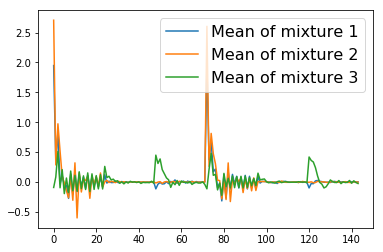

In [71]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

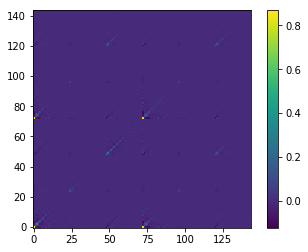

In [72]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

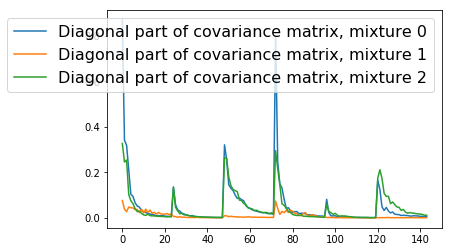

In [73]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

In [74]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    x, frame_sample = librosa.load(src_path, sr=fs, dtype=float64)
    f0, timeaxis = pyworld.dio(x, frame_sample, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, frame_sample)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, frame_sample)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, frame_sample)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, frame_sample, frame_period)
        
    return waveform

Compare results with [this](http://people.tamu.edu/~guanlong.zhao/icassp18_demo.html)

In [ ]:
for i, (src_path, tgt_path) in enumerate(zip(src_speaker.test_paths, tgt_speaker.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    src, _ = librosa.load(src_path, sr=fs, dtype=float64)
    tgt, _ = librosa.load(tgt_path, sr=fs, dtype=float64)
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: BDL_arctic_a0074.wav


Target: HKK_arctic_a0074.wav


w/o MLPG


w/ MLPG


2-th sample
Source: BDL_arctic_a0019.wav


Target: HKK_arctic_a0019.wav


w/o MLPG


w/ MLPG


3-th sample
Source: BDL_arctic_a0119.wav


Target: HKK_arctic_a0119.wav


w/o MLPG


w/ MLPG


4-th sample
Source: BDL_arctic_a0079.wav


Target: HKK_arctic_a0079.wav


w/o MLPG


w/ MLPG


5-th sample
